In [1]:
import tensorflow as tf
import time
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, concatenate
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras import Input, Model
from tensorflow.keras.callbacks import *
from tensorflow.python.client import device_lib
import numpy as np
import re
from tensorflow.keras.models import load_model
import sys
import string
import nltk
from nltk.stem.isri import ISRIStemmer

In [ ]:
data_file = 'arabic_dataset_classifiction.csv'

data = open(data_file, encoding='utf-8').read()
corpus = data.lower().split("\n")
print("first article in the dataset",corpus[0])

first article in the dataset بين أستوديوهات ورزازات وصحراء مرزوكة وآثار وليلي ثم الرباط والبيضاء انتهى المخرج المغربي سهيل بن بركة من تصوير مشاهد عمله السينمائي الجديد الذي خصصه لتسليط الضوء عن حياة الجاسوس الإسباني دومينغو باديا الذي عاش فترة من القرن التاسع عشر بالمغرب باسم علي باي هذا الفيلم الذي اختار له مخرجه عنوان حلم خليفة يصور حياة علي باي العباسي الذي ما زال أحد أحياء طنجة يحمل اسمه عاش حياة فريدة متنكرا بشخصية تاجر عربي من سلالة الرسول صلى الله عليه وسلم فيما كان يعمل جاسوسا لحساب إسبانيا وكشف مخرج الفيلم سهيل بن بركة في تصريح لهسبريس أن الفيلم السينمائي دخل مرحلة التوضيب التي تتم خارج المغرب مبرزا أن الفيلم الذي يروي حياة الجاسوس الإسباني دومينغو باديا منذ أن قرر من طنجة بدء رحلاته نحو عدد من المناطق في العالم الإسلامي بداية القرن العشرين سيكون جاهزا بعد شهرين ويجمع الفيلم السينمائي عددا من الممثلين من مختلف الجنسيات واختار لدور البطولة الممثلة السينمائية الإيطالية كارولينا كريشنتيني للقيام بدور الإنجليزية الليدي هستر ستانهوب التي اشتهرت في الكتب الغربية بـ زنوبيا والتي عاشت

In [ ]:
import string

def remove_repeated_characters(text):
    cleaned_text = re.sub(r'([ء-ي])\1{2,}', r'\1', text)
    return cleaned_text

def clean_text(text):
    clean = re.sub(r'\.{2,}$',' .',text)
    clean = re.sub(r'\.{2,}',' ..',clean)
    return clean

def remove_english(text):

    english_characters = re.compile(r'[a-zA-Z]')
    text = re.sub(english_characters, '', text)

    return text

def remove_elongation(text):
    cleaned_text =re.sub(r'([\u0600-\u06FF])ـــ*', r'\1', text)
    return cleaned_text

def remove_diacritics(text):
    arabic_diacritics = re.compile("""
                                \u064E | #Fatha
                                \u064B | #Tanwin Fath
                                \u0650 | #Kasra
                                \u064D | #Tanwin Kasr
                                \u064F | #Damma
                                \u064C | #Tanwin Damm
                                \u0652 | #Sukun
                                \u0651 | #Shadda
                                \u0640 | #Tatwil/Kashida
                             """, re.VERBOSE)

    text = re.sub(arabic_diacritics, '', text)

    return text

def remove_spaces(text):
    cleaned_text =re.sub(r'(\s+)', ' ', text)
    return cleaned_text

def remove_punctuation(text):
    arabic_punctuations =  '''`÷×؛<>_()*&^%][ـ،:"؟.,'{}~¦+|!”…“–ـ/«»$£•●'''
    english_punctuations = string.punctuation
    numbers = "1234567890١٢٣٤٥٦٧٨٩٠"
    bad_characters = "�¿áóóó□"
    punctuations_list = arabic_punctuations + english_punctuations + numbers +  bad_characters

    replace_slash = str.maketrans('/', ' ', '')
    text = text.translate(replace_slash)
    remove_punc = str.maketrans('', '', punctuations_list)
    text = text.translate(remove_punc)

    return text

def remove_rlo_and_invisible_plus(text):
    # Define a regular expression pattern to match the U+202E and U+2064 characters
    unexpected_pattern = re.compile(r'[^\w\s.,!?]')

    # Use the sub() function to replace matches with an empty string
    cleaned_text = re.sub(unexpected_pattern, '', text)

    return cleaned_text


In [ ]:
sample_test = """
gynecomastia 2020-06-05 15:23:12 ... /اسئلة-طبية/جراحة ",جراحة-العظام " ",جراحة-العظام د. ياسر  د ياااااسر  دياسر  د. ياسرررررر الدباسي جراحة-العظظظظام ٤٤٤٥٣١ ٨ ٦ ٣ ٧ في         هذا      مَرْحَبًا      بِكُمْ  مَرْحَبًا بِكُمْ  الصـــــــــــــــــــــــحة التــــــــــــــــــــــصحر التطــــــــــــــــــــــــويل"""

processed_sample_test_1 = remove_repeated_characters(sample_test)
processed_sample_test_2 = clean_text(processed_sample_test_1)
processed_sample_test_3 = remove_english(processed_sample_test_2)
processed_sample_test_4 = remove_elongation(processed_sample_test_3)
processed_sample_test_5 = remove_diacritics(processed_sample_test_4)
processed_sample_test_6 = remove_spaces(processed_sample_test_5)
processed_sample_test_7 = remove_punctuation(processed_sample_test_6)
processed_sample_test_8 = remove_rlo_and_invisible_plus(processed_sample_test_7)

print("\nProcessed Sample Test 1 (Remove Repeated Characters):")
print(processed_sample_test_1)
print("\nProcessed Sample Test 2 (Remove repeated dots Text):")
print(processed_sample_test_2)
print("\nProcessed Sample Test 3 (Remove English):")
print(processed_sample_test_3)
print("\nProcessed Sample Test 4 (Remove Elongation):")
print(processed_sample_test_4)
print("\nProcessed Sample Test 5 (Remove Diacritics):")
print(processed_sample_test_5)
print("\nProcessed Sample Test 6 (Remove Spaces):")
print(processed_sample_test_6)
print("\nProcessed Sample Test 7 (Remove Punctuation):")
print(processed_sample_test_7)
print("\nProcessed Sample Test 8 (remove_rlo_and_invisible_plus):")
print(processed_sample_test_8)


processed_corpus_1 = [remove_repeated_characters(text) for text in corpus]
processed_corpus_2 = [clean_text(text) for text in processed_corpus_1]
processed_corpus_3 = [remove_english(text) for text in processed_corpus_2]
processed_corpus_4 = [remove_elongation(text) for text in processed_corpus_3]
processed_corpus_5 = [remove_diacritics(text) for text in processed_corpus_4]
processed_corpus_6 = [remove_spaces(text) for text in processed_corpus_5]
processed_corpus_7 = [remove_punctuation(text) for text in processed_corpus_6]
processed_corpus_8 = [remove_rlo_and_invisible_plus(text) for text in processed_corpus_7]


Processed Sample Test 1 (Remove Repeated Characters):

gynecomastia 2020-06-05 15:23:12 ... /اسئلة-طبية/جراحة ",جراحة-العظام " ",جراحة-العظام د. ياسر  د ياسر  دياسر  د. ياسر الدباسي جراحة-العظام ٤٤٤٥٣١ ٨ ٦ ٣ ٧ في         هذا      مَرْحَبًا      بِكُمْ  مَرْحَبًا بِكُمْ  الصـحة التـصحر التطـويل

Processed Sample Test 2 (Remove repeated dots Text):

gynecomastia 2020-06-05 15:23:12  .. /اسئلة-طبية/جراحة ",جراحة-العظام " ",جراحة-العظام د. ياسر  د ياسر  دياسر  د. ياسر الدباسي جراحة-العظام ٤٤٤٥٣١ ٨ ٦ ٣ ٧ في         هذا      مَرْحَبًا      بِكُمْ  مَرْحَبًا بِكُمْ  الصـحة التـصحر التطـويل

Processed Sample Test 3 (Remove English):

 2020-06-05 15:23:12  .. /اسئلة-طبية/جراحة ",جراحة-العظام " ",جراحة-العظام د. ياسر  د ياسر  دياسر  د. ياسر الدباسي جراحة-العظام ٤٤٤٥٣١ ٨ ٦ ٣ ٧ في         هذا      مَرْحَبًا      بِكُمْ  مَرْحَبًا بِكُمْ  الصـحة التـصحر التطـويل

Processed Sample Test 4 (Remove Elongation):

 2020-06-05 15:23:12  .. /اسئلة-طبية/جراحة ",جراحة-العظام " ",جراحة-العظام د. ياسر  د ياسر

In [ ]:
import csv

arabic_letters = "".join([chr(i) for i in range(0x0600, 0x06FF) if chr(i).isprintable()])

processed_corpus_filtered = []
for sentence in processed_corpus_8:
    sentence = " ".join(sentence.split()[:15])
    if sentence != "" and len(sentence.split()) > 3:
        sentence = "<s> " + sentence
        if sentence[4] in arabic_letters:
            processed_corpus_filtered.append(sentence)


csv_file_path = "clean_corpus.csv"

with open(csv_file_path, mode='w', encoding='utf-8', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)

    csv_writer.writerow(['Cleaned Text'])

    # Write the non-deprecated cleaned text to the CSV file
    for text in processed_corpus_filtered:
        csv_writer.writerow([text])

print(f"cleaned corpus has been saved to {csv_file_path}.")


cleaned corpus has been saved to clean_corpus.csv.


In [2]:
from google.colab import files

data_file = files.upload()

Saving News-Multi.ar-en.ar.more.clean to News-Multi.ar-en.ar.more.clean


In [3]:

file_name = list(data_file.keys())[0]

data = data_file[file_name].decode('utf-8')

corpus = data.lower().split("\n")


print(corpus[0])

<s> ترى إحدى المحاكم أن الفقرة من المادة تسمح بإجراء تحقيق حول النية الذاتية للطرفين حتى


In [4]:
vocab_size = 100000 
out_of_vocab = "<unk>"
tokenizer = Tokenizer(num_words=vocab_size, oov_token=out_of_vocab)
tokenizer.fit_on_texts(corpus)

In [ ]:
hi  = tokenizer.texts_to_sequences([corpus[1]])[0]
print(hi)

In [ ]:
max_sequence_len = 15
input_sequences = []
input_sequences_reversed = []
for i in range(1, len(hi)):
        n_gram_sequence = hi[:i+1]
        print('n_gram_sequence ',n_gram_sequence)
        input_sequences.append(n_gram_sequence)
        print('input_sequences ',input_sequences)
        n_gram_sequence_rev = hi[i:]
        print('n_gram_sequence_rev ',n_gram_sequence_rev)
        n_gram_sequence_rev.reverse()
        input_sequences_reversed.append(n_gram_sequence_rev)
        print('input_sequences_reversed ',input_sequences_reversed)

In [ ]:
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
input_sequences_reversed = np.array(pad_sequences(input_sequences_reversed, maxlen=max_sequence_len, padding='pre'))

In [ ]:
print('input_sequences ',input_sequences)
print('input_sequences_reversed ',input_sequences_reversed)

In [5]:

max_sequence_len = 15
input_sequences = []
input_sequences_reversed = []

for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0] # take the line and convert it to sequence of tokens
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)
        n_gram_sequence_rev = token_list[i:]
        n_gram_sequence_rev.reverse()
        input_sequences_reversed.append(n_gram_sequence_rev)
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
input_sequences_reversed = np.array(pad_sequences(input_sequences_reversed, maxlen=max_sequence_len, padding='pre'))


In [12]:
from keras.layers import  SimpleRNN

predictors, label = input_sequences[:,:-1], input_sequences[:,-1]
predictors_rev, label_rev = input_sequences_reversed[:,:-1], input_sequences_reversed[:,-1]

# Test - label must be the same as label_rev, i.e. the current word
print(predictors[1], label[1])
print(predictors_rev[1], label_rev[1])


# Build the model - 2 inputs, 1 output

# Input
left_input = Input(shape=(max_sequence_len-1,), name="left_in")
# right_input = Input(shape=(max_sequence_len-1,),  name="right_in")

# Embedding
left_features = Embedding(vocab_size, 64)(left_input)

# LSTM
left_features = SimpleRNN(64)(left_features)


concat = concatenate([left_features], name='concatenate')

# Dense - output
pred = Dense(vocab_size, activation='softmax', name="pred")(concat)


model2 = Model(
    inputs = [left_input],
    outputs = pred
)


model2.compile(
    optimizer = Adam(),
    loss = SparseCategoricalCrossentropy(),
    metrics = ['accuracy']
)

print(model2.summary())


my_callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=3),
    ModelCheckpoint(filepath='model-dual-input_RNN/model2.{epoch:02d}-{accuracy:.3f}-{val_accuracy:.3f}', verbose=1)
]

start_time = time.time()
history2 = model2.fit(
    {"left_in": predictors},
    {'pred': label},
    epochs=50,
    batch_size=512,
    validation_split=0.02,
    callbacks=my_callbacks
)
end_time = time.time()
training_time = end_time - start_time
print(f"Training Time: {training_time} seconds")

[  0   0   0   0   0   0   0   0   0   0   0   0   2 873] 1015
[   0   88    1 5420 8837  263  179 2820 1675   89    4  102    5 1843] 1015
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 left_in (InputLayer)        [(None, 14)]              0         
                                                                 
 embedding_2 (Embedding)     (None, 14, 64)            640000    
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 64)                8256      
                                                                 
 concatenate (Concatenate)   (None, 64)                0         
                                                                 
 pred (Dense)                (None, 10000)             650000    
                                                                 
Total params: 1298256 (4.95 MB)
Trainable params: 1

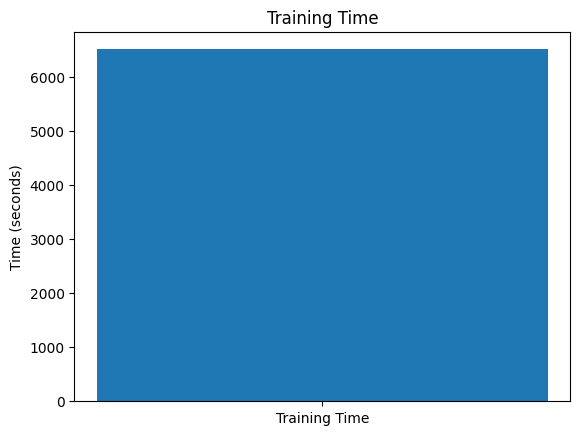

In [13]:
import matplotlib.pyplot as plt

plt.bar(['Training Time'], [training_time])
plt.title('Training Time')
plt.ylabel('Time (seconds)')
plt.savefig('training_time_plot_without.png')
plt.show()

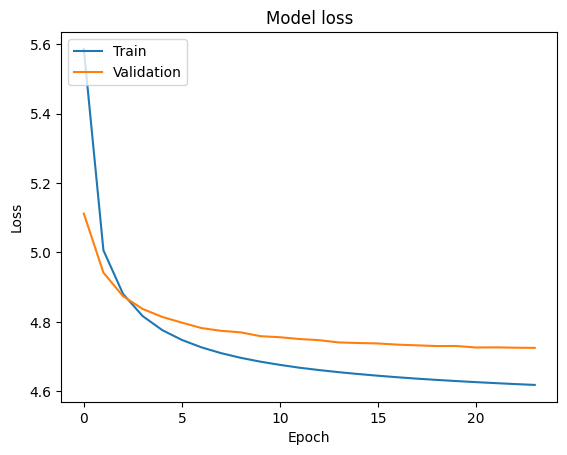

In [14]:
import matplotlib.pyplot as plt
# Plot training & validation loss values
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('model_loss_plot.png')
plt.show()

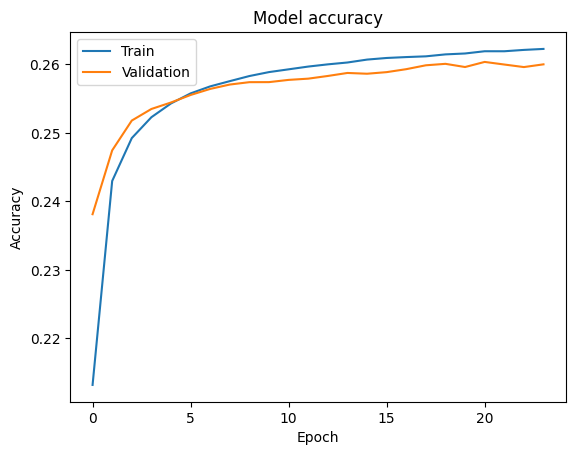

In [15]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Save the accuracy plot as an image
plt.savefig('model_accuracy_plot.png')

# Display the plot (optional)
plt.show()

In [6]:

predictors, label = input_sequences[:,:-1], input_sequences[:,-1]
predictors_rev, label_rev = input_sequences_reversed[:,:-1], input_sequences_reversed[:,-1]

print(predictors[1], label[1])
print(predictors_rev[1], label_rev[1])



# Input
left_input = Input(shape=(max_sequence_len-1,), name="left_in")

# Embedding
left_features = Embedding(vocab_size, 128)(left_input)

# LSTM
left_features = LSTM(64)(left_features)

concat = concatenate([left_features], name='concatenate')

# Dense - output
pred = Dense(vocab_size, activation='softmax', name="pred")(concat)


# Instantiate an end-to-end model predicting the next word based on both the left and right inputs
model = Model(
    inputs = [left_input],
    outputs = pred
)


model.compile(
    optimizer = Adam(),
    loss = SparseCategoricalCrossentropy(),
    metrics = ['accuracy']
)

print(model.summary())


# Define callbacks
my_callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=3),
    ModelCheckpoint(filepath='model-dual-input/model.{epoch:02d}-{accuracy:.3f}-{val_accuracy:.3f}', verbose=1)
]

start_time = time.time()
history = model.fit(
    {"left_in": predictors},
    {'pred': label},
    epochs=100,
    batch_size=512,
    validation_split=0.02,
    callbacks=my_callbacks
)
end_time = time.time()
training_time = end_time - start_time
print(f"Training Time: {training_time} seconds")

[  0   0   0   0   0   0   0   0   0   0   0   0   2 873] 1015
[   0   88    1 5420 8837  263  179 2820 1675   89    4  102    5 1843] 1015
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 left_in (InputLayer)        [(None, 14)]              0         
                                                                 
 embedding (Embedding)       (None, 14, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 concatenate (Concatenate)   (None, 64)                0         
                                                                 
 pred (Dense)                (None, 10000)             650000    
                                                                 
Total params: 1979408 (7.55 MB)
Trainable params: 197

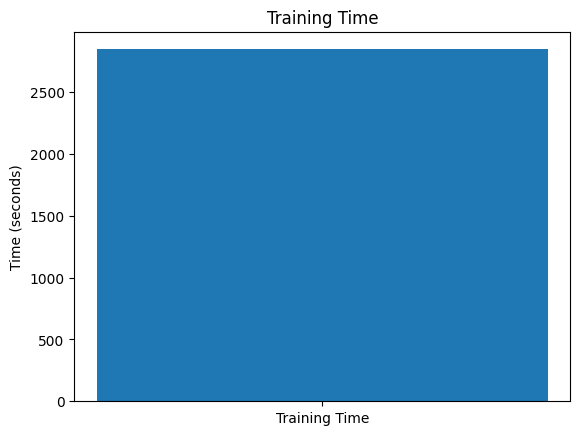

In [8]:
import matplotlib.pyplot as plt

plt.bar(['Training Time'], [training_time])
plt.title('Training Time')
plt.ylabel('Time (seconds)')
plt.savefig('training_time_plot_without.png')
plt.show()

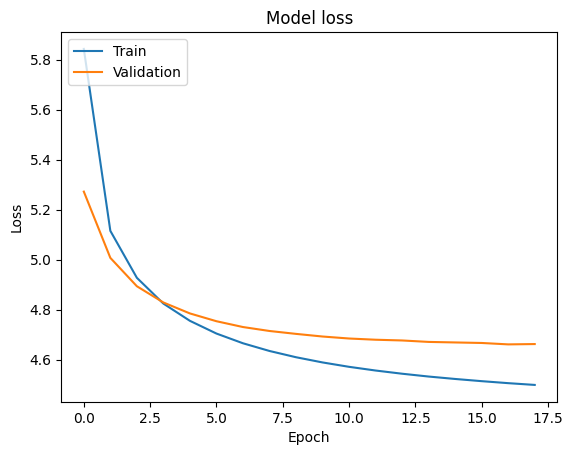

In [9]:
import matplotlib.pyplot as plt
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('model_loss_plot.png')
plt.show()

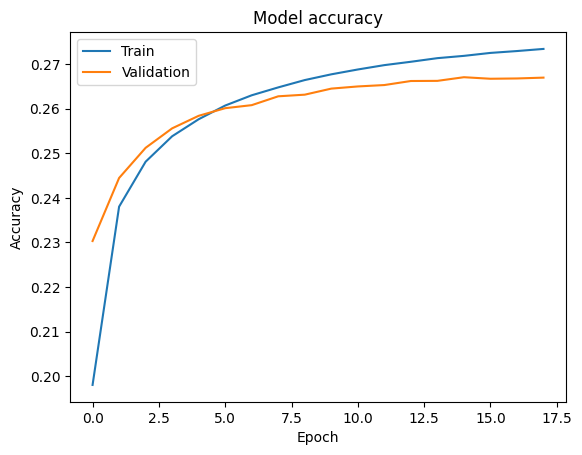

In [10]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Save the accuracy plot as an image
plt.savefig('model_accuracy_plot.png')

# Display the plot (optional)
plt.show()

In [ ]:
predictors, label = input_sequences[:,:-1], input_sequences[:,-1]
predictors_rev, label_rev = input_sequences_reversed[:,:-1], input_sequences_reversed[:,-1]

print(predictors[1], label[1])
print(predictors_rev[1], label_rev[1])



# Input
left_input = Input(shape=(max_sequence_len-1,), name="left_in")
right_input = Input(shape=(max_sequence_len-1,),  name="right_in")

# Embedding
left_features = Embedding(vocab_size, 256)(left_input)
right_features = Embedding(vocab_size, 256)(right_input)

# Bidirectional LSTM
left_features = Bidirectional(LSTM(512, return_sequences = True))(left_features)
right_features = Bidirectional(LSTM(512, return_sequences = True))(right_features)

# LSTM
left_features = LSTM(128)(left_features)
right_features = LSTM(128)(right_features)

# Merge all available features into a single large vector via concatenation
concat = concatenate([left_features, right_features], name='concatenate')

# Dense - output
pred = Dense(vocab_size, activation='softmax', name="pred")(concat)


# Instantiate an end-to-end model predicting the next word based on both the left and right inputs
model = Model(
    inputs = [left_input, right_input],
    outputs = pred
)


model.compile(
    optimizer = Adam(),
    loss = SparseCategoricalCrossentropy(),
    metrics = ['accuracy']
)

print(model.summary())


# Define callbacks
my_callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=3),
    ModelCheckpoint(filepath='model-dual-input/model.{epoch:02d}-{accuracy:.3f}-{val_accuracy:.3f}', verbose=1)
]


# Train the model
model.fit(
    {"left_in": predictors, "right_in": predictors_rev},
    {'pred': label},
    epochs=200,
    batch_size=128,
    validation_split=0.02,
    callbacks=my_callbacks
)


[  0   0   0   0   0   0   0   0   0   0   0   0   2 873] 1015
[   0   88    1 5420 8837  263  179 2820 1675   89    4  102    5 1843] 1015
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 left_in (InputLayer)        [(None, 14)]                 0         []                            
                                                                                                  
 right_in (InputLayer)       [(None, 14)]                 0         []                            
                                                                                                  
 embedding_3 (Embedding)     (None, 14, 256)              2560000   ['left_in[0][0]']             
                                                                                                  
 embedding_4 (Embedding)     (None, 14, 256)       

In [2]:
st = ISRIStemmer()

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mayaa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
print("Loading the spelling the checker model...")
model = load_model("model")

Loading the spelling the checker model...


In [4]:
print("Building the tokenizer...")
data_file = "test_to_eval.csv"
data = open(data_file, encoding='utf-8').read()

Building the tokenizer...


In [5]:
corpus = data.lower().split("\n")
print("First sentence in the corpus:", corpus[0])

First sentence in the corpus: <s> التقدم والاشتراكية يستنكر التمادي في تبخيس عمل الأغلبية الحكوميةجددت قيادة التقدم والاشتراكية أسفها العميق لتمادي


In [9]:
corpus = data.lower().split("\n")
print("First sentence in the corpus:", corpus[0])
vocab_size = 100000 
max_sequence_len = 15
out_of_vocab = "<unk>"
tokenizer = Tokenizer(num_words=vocab_size, oov_token=out_of_vocab)
tokenizer.fit_on_texts(corpus)

In [10]:
def generate_ngrams(text):
    text = "<s>" + text
    
    tokens = nltk.word_tokenize(text)
    tokens = [token for token in tokens if token not in string.punctuation]

    all_grams = []

    for n in range(2, len(tokens)+1):
        grams = [w for w in nltk.ngrams(tokens, n=n)][0]
        
        grams_rev = tokens[n:]
        grams_rev.reverse()
        all_grams.append((list(grams), list(grams_rev)))

    return all_grams

In [11]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import nltk

def evaluate_correction_model(model, texts_to_correct, tokenizer, max_sequence_len, st):

    predictions = []
    true_labels = []

    for text_to_correct in texts_to_correct:
#         print("Currently correcting:", text_to_correct)

        ngrams = generate_ngrams(text_to_correct)
        correct = None
        suggestions = []

        for ngram in ngrams:
            if len(ngram[0]) > 2 and correct != 1 and len(suggestions) != 0:
                seed_text_ltr = " ".join(word for word in ngram[0][:-2]) + " " + suggestions[0][2]
            else:
                seed_text_ltr = " ".join(word for word in ngram[0][:-1])

            current_word = ngram[0][-1]
            seed_text_rtl = " ".join(word for word in ngram[1])

            token_list = tokenizer.texts_to_sequences([seed_text_ltr])[0]
            token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')

            token_list_rev = tokenizer.texts_to_sequences([seed_text_rtl])[0]
            token_list_rev = pad_sequences([token_list_rev], maxlen=max_sequence_len-1, padding='pre')

            predicted_id = np.argmax(model.predict([token_list, token_list_rev],verbose=0), axis=-1)
            predicted_word = tokenizer.sequences_to_texts([predicted_id])[0]

            predicted_probs = model.predict([token_list, token_list_rev],verbose=0)
            predicted_best = np.argsort(-predicted_probs, axis=-1)[0][:4500]

            suggestions = []
            correct = None

            for prob in predicted_best:
                output_word = tokenizer.sequences_to_texts([[prob]])[0]
                ed = nltk.edit_distance(current_word, output_word)

                if ed == 0:
                    correct = 1
                    break
                elif len(current_word) <= 3 and ed == 1:
                    suggestions.append((ed, current_word, output_word))
                elif len(current_word) > 3 and ed <= 2:
                    suggestions.append((ed, current_word, output_word))
                else:
                    continue

            if len(suggestions) > 0:
                for suggest in suggestions:
                    lemmas_cw = [suggest[1], st.suf1(suggest[1]), st.suf32(suggest[1]),
                                 st.pre1(suggest[1]), st.pre32(suggest[1])]

                    lemmas_ow = [suggest[2], st.suf1(suggest[2]), st.suf32(suggest[2]),
                                 st.pre1(suggest[2]), st.pre32(suggest[2])]

                    if correct != 1 and len(suggest[1]) > 7:
                        for l in lemmas_cw:
                            if l in lemmas_ow:
                                correct = 2
                                break

        true_labels.append(1 if correct == 1 else 0)
        predictions.append(1 if correct == 2 or correct == 1 else 0)

    # Calculate and print evaluation metrics
    accuracy = accuracy_score(true_labels, predictions)
    print(f"Accuracy: {accuracy:.4f}")

    # Generate and print classification report
    report = classification_report(true_labels, predictions)
    print("Classification Report:\n", report)

    # Generate and print confusion matrix
    confusion_mat = confusion_matrix(true_labels, predictions)
    print("Confusion Matrix:\n", confusion_mat)

    return accuracy, report, confusion_mat

# Example usage:
# Assuming texts_to_correct is a list of texts, and model is your trained model

accuracy, report, confusion_mat = evaluate_correction_model(model, corpus[:], tokenizer, max_sequence_len, st)

print(accuracy, report, confusion_mat)


Accuracy: 0.9832
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.95      0.97       239
           1       0.98      1.00      0.99       477

    accuracy                           0.98       716
   macro avg       0.99      0.97      0.98       716
weighted avg       0.98      0.98      0.98       716

Confusion Matrix:
 [[227  12]
 [  0 477]]
0.9832402234636871               precision    recall  f1-score   support

           0       1.00      0.95      0.97       239
           1       0.98      1.00      0.99       477

    accuracy                           0.98       716
   macro avg       0.99      0.97      0.98       716
weighted avg       0.98      0.98      0.98       716
 [[227  12]
 [  0 477]]


In [ ]:
print("Building the tokenizer...")
data_file = "test_to_eval.csv"
data = open(data_file, encoding='utf-8').read()

In [ ]:
corpus = data.lower().split("\n")
print("First sentence in the corpus:", corpus[0])

In [ ]:
vocab_size = 100000 
max_sequence_len = 15
out_of_vocab = "<unk>"
tokenizer = Tokenizer(num_words=vocab_size, oov_token=out_of_vocab)
tokenizer.fit_on_texts(corpus)

In [ ]:
# RWE
texts_to_correct = ["وتدعو الحريق إلى مواصلة التماس الآراء والتعليقات من جميع الجهات المعنية",
                    "الفعالية المثلي في هذا الصدد تتعزز بالتعاون الدولي الواسع النطاق",
                    "لم يبدأ تنفيذ خطط العمل الدولية إلا عدد صفير من البلدان",
                    "توجه السكر إلى الدول الأعضاء",
                    "التمييز ضد المرأة فيما يتعلق بحصولها على القرود المصرفية",
                    "تدعيم تلك المناطق في النصف الجنوبي للكرة العرضية والمناطق المجاورة",
                    "العمارات العربية المتحدة",
                    "تؤيد فكره عقد مؤتمر للدول الأطراف",
                    "قدمت مضر مشروع القرار الموصى به في تقرير اللجنة",
                    "آثار التغييرات في أشعار الصرف ومعدلات التضخم",
                    "مرسوم مجلس قيادة الثروة",
                    "إسرار المجتمع الدولي على وضع حد لإفلات مرتكبي هذه الجرائم من العقاب",
                    "التدخن في الشؤون التي تكون من صميم سيادة الدول",
                    "زهور حركات عنصرية تدعو إلى العنف",
                    "تعيد تأكيد حق الشغب الفلسطيني في تقرير المصير",
                    "تؤكد أن التثقيف في مجال حقوق الإنسان أمر أثاثي في تغيير الاتجاهات",
                    "المزيد من الجهود لمعالجة الغرق بين أجور الجنسين",
                    "يقضي بتخفيض شعر الفائدة",
                    "منظمة الأمم المتحدة للتربية والألم والثقافة",
                    "حق الشعوب في تقرير المسير وغيره من حقوق الإنسان",
                    ]

In [ ]:
# NWE
texts_to_correct = ["وتدعو الفريق إلى مواصله التماس الآراء والتعليقات من جميع الجهات المعنية",
                    "الفعالية المثلى في هذا الصدد تتعززز بالتعاون الدولي الواسع النطاق",
                    "لم يبدأ تفنيذ خطط العمل الدولية إلا عدد صغير من البلدان",
                    "توجة الشكر إلى الدول الأعضاء",
                    "التمييز ضد المرأة فيما يتعلق بحصولها على القروض المرصفية",
                    "تدعيم تلك المناطق في النصف الجنوبي للكرة الأرظية والمناطق المجاورة",
                    "اشتركت في تقديمه الأردن والإمارات العربيع المتحدة",
                    "تؤيد فكرة عقد مؤتمر للدول الأتراف",
                    "قدمت مصر مشروع القرار المصى به في تقرير اللجنة",
                    "آثار التغييرات في أسعار الصرف ومعدلت التضخم",
                    "مرسوم مجلس غيادة الثورة",
                    "إصرار المجتمع الدولي على وضع حد لإفلات مرتكبي هذه الجرايم من العقاب",
                    "التدخل في الشؤون التي تكون من صميم يادة الدول",
                    "ضهور حركات عنصرية تدعو إلى العنف",
                    "تعيد تأكيد حق الشاعب الفلسطيني في تقرير المصير",
                    "تؤكد أن التثقيف في مجال حقوق الإنسان أمر أساسي في تايير الاتجاهات",
                    "المذيد من الجهود لمعالجة الفرق بين أجور الجنسين",
                    "يقضي بتخفيد سعر الفائدة",
                    "منظمة الأمم المتحده للتربية والعلم والثقافة",
                    "حق الشعوب في تقرير المصير وغيره من حقوق الإنثان"
                    ]


In [ ]:
test = generate_ngrams("حق الشعوب في تقرير المسير وغيره من حقوق الإنسان")
print(test)
for test in test:
    print(test)
#     print(test[0][-1])
    seed_text_ltr = " ".join(word for word in test[0][:-1])
    print()
    print('seed_text_ltr ',seed_text_ltr)
    print('current word ',test[0][-1])
    seed_text_rtl = " ".join(word for word in test[1])
    print('seed_text_rtl ',seed_text_rtl)
    token_list = tokenizer.texts_to_sequences([seed_text_ltr])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')

    token_list_rev = tokenizer.texts_to_sequences([seed_text_rtl])[0]
    token_list_rev = pad_sequences([token_list_rev], maxlen=max_sequence_len-1, padding='pre')

    
    predicted_id = np.argmax(model.predict([token_list, token_list_rev]), axis=-1)
    predicted_word = tokenizer.sequences_to_texts([predicted_id])[0]
    print("predicted_word ",predicted_word)

In [ ]:
correct = 2
suggestions = []
for ngram in test:
            
    if len(ngram[0]) > 2 and correct != 1 and len(suggestions) != 0:
        seed_text_ltr = " ".join(word for word in ngram[0][:-2]) + " " + suggestions[0][2]
    else:
        seed_text_ltr = " ".join(word for word in ngram[0][:-1])
        
print(seed_text_ltr)

print( ngram[0][:-1])
seed_text_rtl = " ".join(word for word in ngram[1])
# print(ngram[0])

In [ ]:
for text_to_correct in texts_to_correct:
    
    print("Currently correcting:", text_to_correct)
        
    ngrams = generate_ngrams(text_to_correct)
    correct = None
    suggestions = []
    
    for ngram in ngrams:
            
        if len(ngram[0]) > 2 and correct != 1 and len(suggestions) != 0:
            seed_text_ltr = " ".join(word for word in ngram[0][:-2]) + " " + suggestions[0][2]
            print('suggestions[0][2] ',suggestions[0][2])
        else:
            seed_text_ltr = " ".join(word for word in ngram[0][:-1])
            
        print('suggestions ',suggestions)
        print('seed_text_ltr ', seed_text_ltr)
        
        current_word = ngram[0][-1]
        print('current_word ', ngram[0][-1])
        seed_text_rtl = " ".join(word for word in ngram[1])
        print(seed_text_ltr, "->", current_word, "->", seed_text_rtl)

        token_list = tokenizer.texts_to_sequences([seed_text_ltr])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')

        token_list_rev = tokenizer.texts_to_sequences([seed_text_rtl])[0]
        token_list_rev = pad_sequences([token_list_rev], maxlen=max_sequence_len-1, padding='pre')

        predicted_id = np.argmax(model.predict([token_list, token_list_rev]), axis=-1)
        predicted_word = tokenizer.sequences_to_texts([predicted_id])[0]
        print("predicted_word ",predicted_word)


        predicted_probs = model.predict([token_list, token_list_rev])
        predicted_best = np.argsort(-predicted_probs, axis=-1)[0][:4500]
        
        suggestions = []
        correct = None

        for prob in predicted_best:
            output_word = tokenizer.sequences_to_texts([[prob]])[0]
            ed = nltk.edit_distance(current_word, output_word)

            if ed ==0:
                print("I got this one; it seems correct -->", current_word, "=", output_word)
                correct = 1
                break
            elif len(current_word)<=3 and ed ==1:
                suggestions.append((ed, current_word, output_word))
            elif len(current_word)>3 and ed <=2:
                suggestions.append((ed, current_word, output_word))
            else:
                continue
                
        
        
        if len(suggestions) > 0:  
            for suggest in suggestions:
                lemmas_cw = []
                lemmas_cw.append(suggest[1])
                lemmas_cw.append(st.suf1(suggest[1]))
                lemmas_cw.append(st.suf32(suggest[1]))
                lemmas_cw.append(st.pre1(suggest[1]))
                lemmas_cw.append(st.pre32(suggest[1]))
                
                lemmas_ow = []
                lemmas_ow.append(suggest[2])
                lemmas_ow.append(st.suf1(suggest[2]))
                lemmas_ow.append(st.suf32(suggest[2]))
                lemmas_ow.append(st.pre1(suggest[2]))
                lemmas_ow.append(st.pre32(suggest[2]))
                
                if correct != 1 and len(suggest[1]) > 7:
                    for l in lemmas_cw:
                        if l in lemmas_ow:
                            correct = 2
                            print("I got the lemma; it seems correct -->", current_word, "~", suggest[2])
                    
      
        print("Suggestions:", " - ".join([suggest[2] for suggest in suggestions]))
#         print()
 

        if correct == 2:
            print("Not sure")
        elif correct == 1:
            print("CORRECT")
        elif correct != 1 and len(suggestions) > 0:
            correct = 0
            print("WRONG")
        elif correct != 1 and len(suggestions) == 0:
            print("I do not know!")


        print("-------")


In [ ]:
true_labels = []
predicted_labels = []

texts_to_correct = []
texts_to_correct = []
inp = input(texts_to_correct)
texts_to_correct.append(inp)

for text_to_correct in texts_to_correct:
    
    print("Currently correcting:", text_to_correct)
        
    ngrams = generate_ngrams(text_to_correct)
    correct = None
    suggestions = []
    
    for ngram in ngrams:
            
        if len(ngram[0]) > 2 and correct != 1 and len(suggestions) != 0:
            seed_text_ltr = " ".join(word for word in ngram[0][:-2]) + " " + suggestions[0][2]
        else:
            seed_text_ltr = " ".join(word for word in ngram[0][:-1])
        
        current_word = ngram[0][-1]
        seed_text_rtl = " ".join(word for word in ngram[1])
        print(seed_text_ltr, "->", current_word, "->", seed_text_rtl)

        token_list = tokenizer.texts_to_sequences([seed_text_ltr])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')

        token_list_rev = tokenizer.texts_to_sequences([seed_text_rtl])[0]
        token_list_rev = pad_sequences([token_list_rev], maxlen=max_sequence_len-1, padding='pre')

        predicted_id = np.argmax(model.predict([token_list, token_list_rev]), axis=-1)
        predicted_word = tokenizer.sequences_to_texts([predicted_id])[0]
        print(predicted_word)


        predicted_probs = model.predict([token_list, token_list_rev])
        predicted_best = np.argsort(-predicted_probs, axis=-1)[0][:4500]
        
        suggestions = []
        correct = None
        true_labels.append(current_word)
        predicted_labels.append(predicted_word)

        for prob in predicted_best:
            output_word = tokenizer.sequences_to_texts([[prob]])[0]
            ed = nltk.edit_distance(current_word, output_word)

            if ed ==0:
                print("I got this one; it seems correct -->", current_word, "=", output_word)
                correct = 1
                break
            elif len(current_word)<=3 and ed ==1:
                suggestions.append((ed, current_word, output_word))
            elif len(current_word)>3 and ed <=2:
                suggestions.append((ed, current_word, output_word))
            else:
                continue
                
        
        
        if len(suggestions) > 0:  
            for suggest in suggestions:
                lemmas_cw = []
                lemmas_cw.append(suggest[1])
                lemmas_cw.append(st.suf1(suggest[1]))
                lemmas_cw.append(st.suf32(suggest[1]))
                lemmas_cw.append(st.pre1(suggest[1]))
                lemmas_cw.append(st.pre32(suggest[1]))
                
                lemmas_ow = []
                lemmas_ow.append(suggest[2])
                lemmas_ow.append(st.suf1(suggest[2]))
                lemmas_ow.append(st.suf32(suggest[2]))
                lemmas_ow.append(st.pre1(suggest[2]))
                lemmas_ow.append(st.pre32(suggest[2]))
                
                if correct != 1 and len(suggest[1]) > 7:
                    for l in lemmas_cw:
                        if l in lemmas_ow:
                            correct = 2
                            print("I got the lemma; it seems correct -->", current_word, "~", suggest[2])
                    

        print("Suggestions:", " - ".join([suggest[2] for suggest in suggestions]))

        if correct == 2:
            print("Not sure")
        elif correct == 1:
            print("CORRECT")
        elif correct != 1 and len(suggestions) > 0:
            correct = 0
            print("WRONG")
        elif correct != 1 and len(suggestions) == 0:
            print("I do not know!")


        print("-------")


In [ ]:
import re
import string
from collections import Counter
import numpy as np

In [ ]:
def read_corpus(filename):
  with open(filename, encoding='utf-8') as file:
    lines = file.readlines()
    words = []
    for line in lines:
#         data = open(data_file, encoding='utf-8').read()
      words += re.findall(r'\w+', line.lower())

  return words

In [ ]:
words = read_corpus("arabic_dataset_classifiction.csv")
print(f"There are {len(words)} total words in the corpus")

In [ ]:
vocabs = set(words)
print(f"There are {len(vocabs)} unique words in the vocabulary")

In [ ]:
word_counts = Counter(words)
print(word_counts["يقول"])

In [ ]:
total_word_count = float(sum(word_counts.values()))
word_probas = {word: word_counts[word] / total_word_count for word in word_counts.keys()}

In [ ]:
print(word_probas["يقول"])

In [ ]:
def split(word):
  return [(word[:i], word[i:]) for i in range(len(word) + 1)]

In [ ]:
print(split("يقول"))

In [ ]:
def delete(word):
  return [l + r[1:] for l,r in split(word) if r]

In [ ]:
print(delete("يقول"))

In [ ]:
def swap(word):
  return [l + r[1] + r[0] + r[2:] for l, r in split(word) if len(r)>1]

In [ ]:
print(swap("يقول"))

In [ ]:
# string.ascii_lowercase
arabic_alphabet = 'ابتثجحخدذرزسشصضطظعغفقكلمنهوي'

In [ ]:
def replace(word):
#   letters = string.ascii_lowercase
  letters = arabic_alphabet
  return [l + c + r[1:] for l, r in split(word) if r for c in letters]

In [ ]:
print(replace("يقول"))

In [ ]:
def insert(word):
#   letters = string.ascii_lowercase
  letters = arabic_alphabet
  return [l + c + r for l, r in split(word) for c in letters]

In [ ]:
print(insert("يقول"))

In [ ]:
def edit1(word):
  return set(delete(word) + swap(word) + replace(word) + insert(word))

In [ ]:
print(edit1("يقول"))

In [ ]:
def edit2(word):
  return set(e2 for e1 in edit1(word) for e2 in edit1(e1))

In [ ]:
print(edit2("يقول"))

In [ ]:
def correct_spelling(word, vocabulary, word_probabilities):
  if word in vocabulary:
    print(f"{word} is already correctly spelt")
    return

  suggestions = edit1(word) or edit2(word) or [word]
  best_guesses = [w for w in suggestions if w in vocabulary]
  return [(w, word_probabilities[w]) for w in best_guesses]

In [ ]:
word = "ؤجاء"
corrections = correct_spelling(word, vocabs, word_probas)

if corrections:
  print(corrections)
  probs = np.array([c[1] for c in corrections])
  best_ix = np.argmax(probs)
  correct = corrections[best_ix][0]
  print(f"{correct} is suggested for {word}")

In [ ]:
class SpellChecker(object):

  def __init__(self, corpus_file_path):
    with open(corpus_file_path, encoding='utf-8') as file:
      lines = file.readlines()
      words = []
      for line in lines:
        words += re.findall(r'\w+', line.lower())

    self.vocabs = set(words)
    self.word_counts = Counter(words)
    total_words = float(sum(self.word_counts.values()))
    self.word_probas = {word: count / total_words for word, count in self.word_counts.items()}
    

  def _level_one_edits(self, word):
    letters = arabic_alphabet
    splits = [(word[:i], word[i:]) for i in range(len(word) + 1)]
    deletes = [l + r[1:] for l,r in splits if r]
    swaps = [l + r[1] + r[0] + r[2:] for l, r in splits if len(r)>1]
    replaces = [l + c + r[1:] for l, r in splits if r for c in letters]
    inserts = [l + c + r for l, r in splits for c in letters]

    return set(deletes + swaps + replaces + inserts)

  def _level_two_edits(self, word):
    return set(e2 for e1 in self._level_one_edits(word) for e2 in self._level_one_edits(e1))

  def check(self, word):
    candidates = self._level_one_edits(word) or self._level_two_edits(word) or [word]
    valid_candidates = [w for w in candidates if w in self.vocabs]
    return sorted([(c, self.word_probas[c]) for c in valid_candidates], key=lambda tup: tup[1], reverse=True)


In [ ]:
checker = SpellChecker("arabic_dataset_classifiction.csv")

In [ ]:
checker.check("هرام")